Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.094720 s


'compile' took 1.668601 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.78e+00, 3.74e+00, 0.00e+00, 1.04e+05, 4.95e+04, 5.80e+03, 1.09e-01, 4.94e-02, 6.93e-02]    [2.12e+00, 4.83e+00, 0.00e+00, 3.79e+04, 3.86e+04, 6.38e+03, 1.09e-01, 4.94e-02, 6.93e-02]    []  
1000      [1.45e+00, 1.88e+00, 0.00e+00, 1.65e+03, 1.23e+03, 5.23e+02, 7.40e-04, 3.28e-04, 1.94e-01]    [1.11e+00, 2.24e+00, 0.00e+00, 2.10e+03, 1.31e+03, 5.51e+02, 7.40e-04, 3.28e-04, 1.94e-01]    []  

Best model at step 1000:
  train loss: 3.40e+03
  test loss: 3.97e+03
  test metric: []

'train' took 48.760311 s

Saving loss history to c:\Users\yesda\Desktop\PINN 

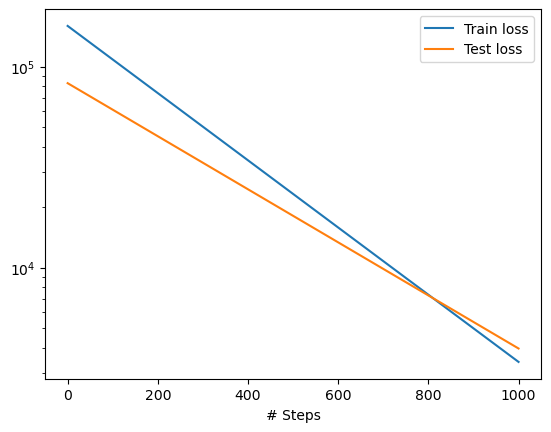

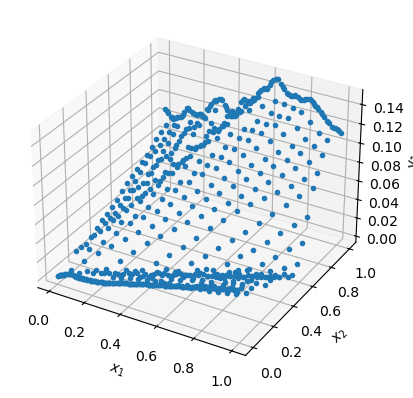

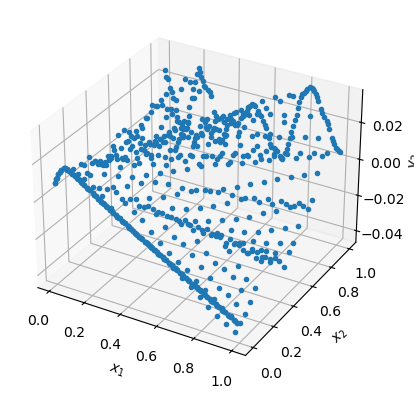

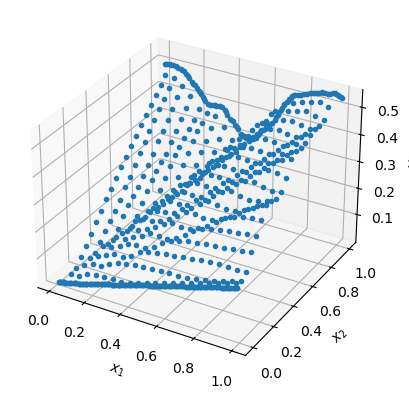

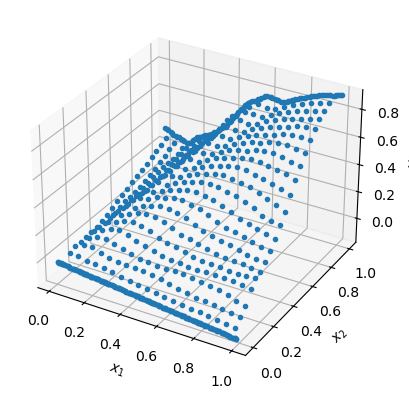

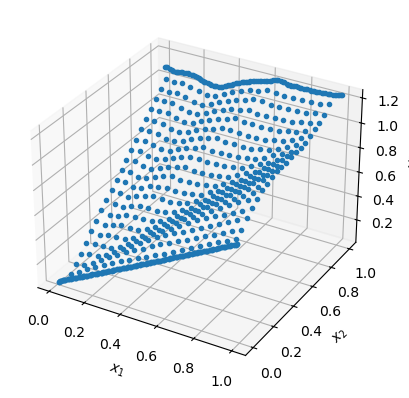

In [1]:
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt

# Constants
traction = 1
E = 2e2
L = 1  # mm
nu = 0.3
qx = 0
qy = 0

# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and x[1]==0

def boundary_top(x, on_boundary):
    return on_boundary and x[1]==L

# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, lambda x: traction, boundary_top, component=3)


# Define the PDE
def pde(x, y):
    sigma_xx=y[:,2:3]
    sigma_yy=y[:,3:4]
    sigma_xy=y[:,4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    gamma_xy = duxdy + duydx
    eps_xx = duxdx
    eps_yy = duydy
    d2eps_xx_dy2 = dde.grad.hessian(eps_xx, x, component=0, i=1, j=1)
    d2eps_yy_dx2 =  dde.grad.hessian(eps_yy, x, component=0, i=0, j=0)
    d2eps_xy_dxdy = dde.grad.hessian(gamma_xy, x, component=0,i=0, j=1)

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    eq4 = sigma_xx - (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5 = sigma_yy - (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6 = sigma_xy - (E / (2 * (1 + nu))) * gamma_xy
    
    return [eq1,eq2,eq3,eq4,eq5,eq6]

# Data definition
data = dde.data.PDE(
    geom,
    pde,
    [
        bc_bottom_u_x,
        bc_bottom_u_y,
        bc_top_sigma_yy
    ],
    num_domain=400,
    num_boundary=400,
    num_test=400,
)

# Neural network
net = dde.maps.FNN([2] + [200] * 10 + [5], "relu", "He normal")

# Model
model = dde.Model(data, net)

# Compile the model with adjusted loss weights
model.compile("adam",lr=1e-5)

# Train the model
losshistory, train_state = model.train(epochs=1000, display_every=1000) #Increase iteration for better result. I set it low to test

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


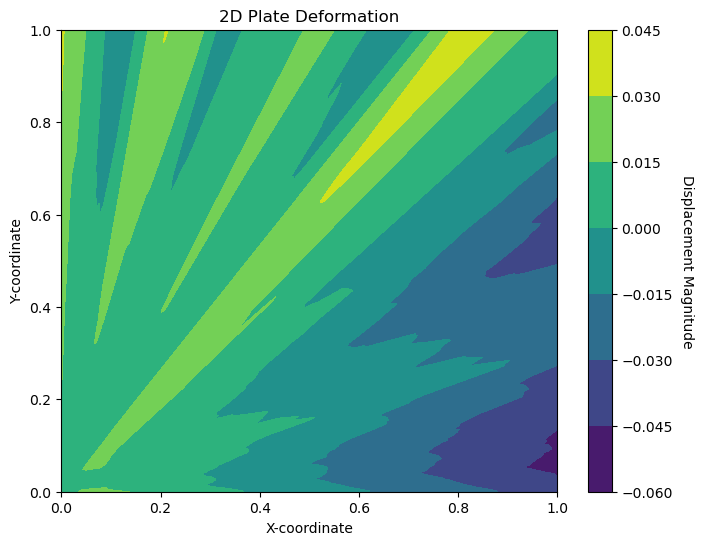

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x_test = np.linspace(0, L, 3000)  # x-coordinates
y_test = np.linspace(0, L, 3000)  # y-coordinates
x_grid, y_grid = np.meshgrid(x_test, y_test)  # Create a mesh grid

# Flatten the grid points into a list of coordinates
test_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Predict displacements using the trained model
u_pred = model.predict(test_points)

# Extract the x and y displacements from the predictions
u_x_pred = u_pred[:, 0].reshape(x_grid.shape)
u_y_pred = u_pred[:, 1].reshape(y_grid.shape)

# Compute the magnitude of the deformation at each point
deformation_magnitude =  u_y_pred



plt.figure(figsize=(8, 6))

# Plot the displacement magnitude as a contour plot
contour = plt.contourf(x_grid, y_grid, deformation_magnitude, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label('Displacement Magnitude', rotation=270, labelpad=15)

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('2D Plate Deformation')
plt.show()
